<div style="color:black; font-size:28px">Multi Objactive Optimization using Genetic Algorithm</div>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1120)

In [2]:
from datetime import date
from nsepy import get_history
stocks_data = get_history(symbol='IBM',
                   start=date(2000,4,29),
                   end=date(2022,4,29))

stocks_data.to_csv('stocks_data.csv')
stocks_data.reset_index(level=0, inplace=True)

In [3]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'], format='%Y-%m-%d')

In [4]:
stocks_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2019-05-08,IBMFNIFTY,EQ,117.45,140.0,140.0,140.0,140.0,140.0,140.0,2,28000000.0,1,2,1.0
1,2019-05-09,IBMFNIFTY,EQ,140.0,118.0,135.0,112.0,112.0,112.0,112.34,6311,70898625000.0,105,3402,0.5391
2,2019-05-10,IBMFNIFTY,EQ,112.0,112.8,113.85,100.58,107.25,107.25,108.22,597,6460669000.0,20,369,0.6181
3,2019-05-13,IBMFNIFTY,EQ,107.25,107.25,112.0,105.35,105.55,105.55,106.65,1226,13075557000.0,44,1084,0.8842
4,2019-05-14,IBMFNIFTY,EQ,105.55,111.0,111.0,100.58,107.96,107.84,104.97,1468,15410039000.000002,57,960,0.654


In [5]:
stocks_data_duplicate= stocks_data

In [6]:
stocks_data_high = stocks_data['High']
stocks_data_date = stocks_data['Date']

Text(0.5, 1.0, 'Stock Price')

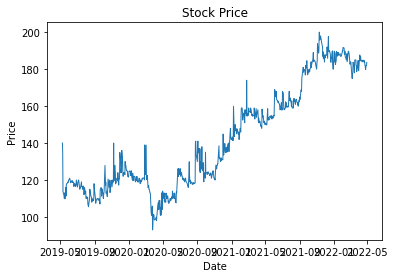

In [7]:
plt.plot(stocks_data_date,stocks_data_high, linewidth=1)
plt.xlabel("Date")
plt.ylabel('Price')
plt.title("Stock Price")

In [8]:
train_size = int(stocks_data.shape[0]*0.80)

In [9]:
stocks_data = np.asarray(stocks_data_high, dtype=np.float64).reshape(-1, 1)

In [10]:
train_data = stocks_data[:train_size]
test_data = stocks_data[train_size:]

In [11]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

In [12]:
def train_evaluate(ga_individual_solution):   
   
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
  
    if window_size == 0 or num_units == 0:
        return 100, 
    
  
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
   
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [13]:
population_size = 5
num_generations = 5
gene_length = 15

creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
ngen = num_generations, verbose = False)


Window Size:  36 , Num of Units:  92
Epoch 1/50
14/14 [==============================] - 10s 53ms/step - loss: 17655.4336
Epoch 2/50
14/14 [==============================] - 1s 48ms/step - loss: 17277.1777
Epoch 3/50
14/14 [==============================] - 1s 63ms/step - loss: 16685.0742
Epoch 4/50
14/14 [==============================] - 1s 48ms/step - loss: 16038.4014
Epoch 5/50
14/14 [==============================] - 1s 57ms/step - loss: 15373.0615
Epoch 6/50
14/14 [==============================] - 1s 48ms/step - loss: 14727.4805
Epoch 7/50
14/14 [==============================] - 1s 70ms/step - loss: 14337.2412
Epoch 8/50
14/14 [==============================] - 1s 63ms/step - loss: 13953.1074
Epoch 9/50
14/14 [==============================] - 1s 60ms/step - loss: 13502.6973
Epoch 10/50
14/14 [==============================] - 1s 57ms/step - loss: 13100.9590
Epoch 11/50
14/14 [==============================] - 1s 64ms/step - loss: 12719.3135
Epoch 12/50
14/14 [================

15/15 [==============================] - 2s 163ms/step - loss: 121.1991
Epoch 47/50
15/15 [==============================] - 2s 145ms/step - loss: 113.8843
Epoch 48/50
15/15 [==============================] - 2s 157ms/step - loss: 105.8969
Epoch 49/50
15/15 [==============================] - 3s 167ms/step - loss: 95.8314
Epoch 50/50
15/15 [==============================] - 2s 141ms/step - loss: 87.3249
Validation RMSE:  8.104386320467189 


Window Size:  49 , Num of Units:  305
Epoch 1/50
14/14 [==============================] - 9s 219ms/step - loss: 16862.6738
Epoch 2/50
14/14 [==============================] - 3s 190ms/step - loss: 15077.2119
Epoch 3/50
14/14 [==============================] - 3s 200ms/step - loss: 13430.8623
Epoch 4/50
14/14 [==============================] - 3s 204ms/step - loss: 12413.1807
Epoch 5/50
14/14 [==============================] - 3s 207ms/step - loss: 11479.2256
Epoch 6/50
14/14 [==============================] - 3s 221ms/step - loss: 10622.4189
Epoch 7

15/15 [==============================] - 1s 62ms/step - loss: 163.3011
Epoch 42/50
15/15 [==============================] - 1s 62ms/step - loss: 149.7536
Epoch 43/50
15/15 [==============================] - 1s 62ms/step - loss: 137.2786
Epoch 44/50
15/15 [==============================] - 1s 62ms/step - loss: 127.6839
Epoch 45/50
15/15 [==============================] - 1s 63ms/step - loss: 117.0983
Epoch 46/50
15/15 [==============================] - 1s 62ms/step - loss: 108.2338
Epoch 47/50
15/15 [==============================] - 1s 62ms/step - loss: 101.7744
Epoch 48/50
15/15 [==============================] - 1s 63ms/step - loss: 92.5195
Epoch 49/50
15/15 [==============================] - 1s 62ms/step - loss: 85.9822
Epoch 50/50
15/15 [==============================] - 1s 62ms/step - loss: 81.1877
Validation RMSE:  7.677171480124152 


Window Size:  14 , Num of Units:  278
Epoch 1/50
15/15 [==============================] - 2s 27ms/step - loss: 16939.0430
Epoch 2/50
15/15 [======

15/15 [==============================] - 0s 7ms/step - loss: 13658.4785
Epoch 38/50
15/15 [==============================] - 0s 7ms/step - loss: 13585.7617
Epoch 39/50
15/15 [==============================] - 0s 7ms/step - loss: 13514.3789
Epoch 40/50
15/15 [==============================] - 0s 7ms/step - loss: 13443.2373
Epoch 41/50
15/15 [==============================] - 0s 7ms/step - loss: 13373.2266
Epoch 42/50
15/15 [==============================] - 0s 7ms/step - loss: 13303.6797
Epoch 43/50
15/15 [==============================] - 0s 7ms/step - loss: 13234.7842
Epoch 44/50
15/15 [==============================] - 0s 7ms/step - loss: 13166.4385
Epoch 45/50
15/15 [==============================] - 0s 7ms/step - loss: 13098.5410
Epoch 46/50
15/15 [==============================] - 0s 7ms/step - loss: 13031.2773
Epoch 47/50
15/15 [==============================] - 0s 7ms/step - loss: 12964.1279
Epoch 48/50
15/15 [==============================] - 0s 7ms/step - loss: 12897.7354
Epoc

14/14 [==============================] - 0s 22ms/step - loss: 9386.3730
Epoch 33/50
14/14 [==============================] - 0s 22ms/step - loss: 9226.4980
Epoch 34/50
14/14 [==============================] - 0s 21ms/step - loss: 9068.2422
Epoch 35/50
14/14 [==============================] - 0s 20ms/step - loss: 8912.4551
Epoch 36/50
14/14 [==============================] - 0s 20ms/step - loss: 8760.1621
Epoch 37/50
14/14 [==============================] - 0s 20ms/step - loss: 8608.6631
Epoch 38/50
14/14 [==============================] - 0s 19ms/step - loss: 8460.3105
Epoch 39/50
14/14 [==============================] - 0s 20ms/step - loss: 8313.8545
Epoch 40/50
14/14 [==============================] - 0s 19ms/step - loss: 8170.0278
Epoch 41/50
14/14 [==============================] - 0s 20ms/step - loss: 8027.2832
Epoch 42/50
14/14 [==============================] - 0s 19ms/step - loss: 7887.3638
Epoch 43/50
14/14 [==============================] - 0s 19ms/step - loss: 7749.9473
Epoc

14/14 [==============================] - 0s 15ms/step - loss: 12331.8662
Epoch 28/50
14/14 [==============================] - 0s 14ms/step - loss: 12200.7549
Epoch 29/50
14/14 [==============================] - 0s 15ms/step - loss: 12071.3525
Epoch 30/50
14/14 [==============================] - 0s 13ms/step - loss: 11943.2471
Epoch 31/50
14/14 [==============================] - 0s 15ms/step - loss: 11817.5381
Epoch 32/50
14/14 [==============================] - 0s 14ms/step - loss: 11693.0195
Epoch 33/50
14/14 [==============================] - 0s 14ms/step - loss: 11570.4355
Epoch 34/50
14/14 [==============================] - 0s 15ms/step - loss: 11448.3936
Epoch 35/50
14/14 [==============================] - 0s 14ms/step - loss: 11328.7705
Epoch 36/50
14/14 [==============================] - 0s 14ms/step - loss: 11209.9805
Epoch 37/50
14/14 [==============================] - 0s 14ms/step - loss: 11092.4209
Epoch 38/50
14/14 [==============================] - 0s 14ms/step - loss: 109

In [19]:
best_individuals = tools.selBest(population,k=1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  36 , Num of Units:  92


In [20]:

X_train,y_train = prepare_dataset(train_data,best_window_size)
X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32,shuffle=True)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/50
18/18 [==============================] - 2s 19ms/step - loss: 17883.2988
Epoch 2/50
18/18 [==============================] - 0s 18ms/step - loss: 17353.4238
Epoch 3/50
18/18 [==============================] - 0s 16ms/step - loss: 16776.8438
Epoch 4/50
18/18 [==============================] - 0s 15ms/step - loss: 15831.4453
Epoch 5/50
18/18 [==============================] - 0s 17ms/step - loss: 15101.1270
Epoch 6/50
18/18 [==============================] - 0s 16ms/step - loss: 14508.6260
Epoch 7/50
18/18 [==============================] - 0s 15ms/step - loss: 14074.0137
Epoch 8/50
18/18 [==============================] - 0s 15ms/step - loss: 13669.0176
Epoch 9/50
18/18 [==============================] - 0s 17ms/step - loss: 13291.9727
Epoch 10/50
18/18 [==============================] - 0s 15ms/step - loss: 12930.0000
Epoch 11/50
18/18 [==============================] - 0s 15ms/step - loss: 12610.8076
Epoch 12/50
18/18 [==============================] - 0s 21ms/step - loss: 

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
test_data = stocks_data_duplicate.iloc[-100:, :]
real_stock_price = test_data.iloc[:,5:6]
real_stock_price.head(10)

,High
638,187.48
639,187.9
640,192.0
641,191.0
642,185.97
643,197.7
644,189.9
645,190.0
646,189.49
647,189.9


In [24]:
mm = MinMaxScaler(feature_range = (0,36))
stock_data_df = mm.fit_transform(real_stock_price)

In [25]:
inputs = real_stock_price
inputs = mm.transform(inputs)
predicted_stock_price = model.predict(inputs)
predicted_stock_price = mm.inverse_transform(predicted_stock_price)

In [26]:
for i in range(len(predicted_stock_price)):
    print(f"Real Price:{real_stock_price.values[i]} --> Predicted Price: {predicted_stock_price[i]}")

Real Price:[187.48] --> Predicted Price: [189.92804]
Real Price:[187.9] --> Predicted Price: [190.17706]
Real Price:[192.0] --> Predicted Price: [192.11116]
Real Price:[191.0] --> Predicted Price: [191.71]
Real Price:[185.97] --> Predicted Price: [188.93042]
Real Price:[197.7] --> Predicted Price: [193.82306]
Real Price:[189.9] --> Predicted Price: [191.22098]
Real Price:[190.0] --> Predicted Price: [191.26768]
Real Price:[189.49] --> Predicted Price: [191.02437]
Real Price:[189.9] --> Predicted Price: [191.22098]
Real Price:[187.9] --> Predicted Price: [190.17706]
Real Price:[183.99] --> Predicted Price: [187.33249]
Real Price:[183.7] --> Predicted Price: [187.06618]
Real Price:[185.9] --> Predicted Price: [188.87991]
Real Price:[185.9] --> Predicted Price: [188.87991]
Real Price:[189.9] --> Predicted Price: [191.22098]
Real Price:[182.8] --> Predicted Price: [186.18091]
Real Price:[182.0] --> Predicted Price: [185.31511]
Real Price:[180.0] --> Predicted Price: [182.8126]
Real Price:[

In [27]:
test_data = stocks_data_duplicate.iloc[-100:, :]
real_stock_price = test_data.iloc[:,4:5]
real_stock_price.head(10)

,Open
638,187.48
639,186.81
640,188.8
641,191.0
642,184.5
643,181.0
644,189.9
645,182.5
646,187.5
647,189.0


In [28]:
mm = MinMaxScaler(feature_range = (0,36))
stock_data_df = mm.fit_transform(real_stock_price)

In [29]:
inputs = real_stock_price
inputs = mm.transform(inputs)
predicted_stock_price = model.predict(inputs)
predicted_stock_price = mm.inverse_transform(predicted_stock_price)

In [30]:
for i in range(len(predicted_stock_price)):
    print(f"Real Price:{real_stock_price.values[i]} --> Predicted Price: {predicted_stock_price[i]}")

Real Price:[187.48] --> Predicted Price: [186.98163]
Real Price:[186.81] --> Predicted Price: [186.7409]
Real Price:[188.8] --> Predicted Price: [187.41147]
Real Price:[191.0] --> Predicted Price: [188.01907]
Real Price:[184.5] --> Predicted Price: [185.7678]
Real Price:[181.0] --> Predicted Price: [183.70242]
Real Price:[189.9] --> Predicted Price: [187.73053]
Real Price:[182.5] --> Predicted Price: [184.69495]
Real Price:[187.5] --> Predicted Price: [186.98856]
Real Price:[189.0] --> Predicted Price: [187.47194]
Real Price:[185.07] --> Predicted Price: [186.03107]
Real Price:[171.05] --> Predicted Price: [171.66293]
Real Price:[183.7] --> Predicted Price: [185.36848]
Real Price:[178.0] --> Predicted Price: [181.05225]
Real Price:[185.0] --> Predicted Price: [185.99963]
Real Price:[177.4] --> Predicted Price: [180.39157]
Real Price:[179.0] --> Predicted Price: [182.05006]
Real Price:[177.5] --> Predicted Price: [180.50502]
Real Price:[173.01] --> Predicted Price: [174.31734]
Real Pric

In [31]:
test_data = stocks_data_duplicate.iloc[-100:, :]
real_stock_price = test_data.iloc[:,8:9]
real_stock_price.head(10)

,Close
638,181.37
639,186.99
640,187.71
641,184.55
642,183.44
643,187.93
644,184.5
645,184.18
646,185.07
647,179.68


In [32]:
mm = MinMaxScaler(feature_range = (0,36))
stock_data_df = mm.fit_transform(real_stock_price)

In [33]:
inputs = real_stock_price
inputs = mm.transform(inputs)
predicted_stock_price = model.predict(inputs)
predicted_stock_price = mm.inverse_transform(predicted_stock_price)

In [34]:
for i in range(len(predicted_stock_price)):
    print(f"Real Price:{real_stock_price.values[i]} --> Predicted Price: {predicted_stock_price[i]}")

Real Price:[181.37] --> Predicted Price: [182.94107]
Real Price:[186.99] --> Predicted Price: [185.09727]
Real Price:[187.71] --> Predicted Price: [185.29483]
Real Price:[184.55] --> Predicted Price: [184.31535]
Real Price:[183.44] --> Predicted Price: [183.88948]
Real Price:[187.93] --> Predicted Price: [185.35262]
Real Price:[184.5] --> Predicted Price: [184.29721]
Real Price:[184.18] --> Predicted Price: [184.17894]
Real Price:[185.07] --> Predicted Price: [184.49838]
Real Price:[179.68] --> Predicted Price: [181.97511]
Real Price:[173.6] --> Predicted Price: [176.15472]
Real Price:[176.6] --> Predicted Price: [179.58138]
Real Price:[177.17] --> Predicted Price: [180.09975]
Real Price:[181.52] --> Predicted Price: [183.01765]
Real Price:[181.0] --> Predicted Price: [182.74622]
Real Price:[178.88] --> Predicted Price: [181.44197]
Real Price:[180.16] --> Predicted Price: [182.27014]
Real Price:[178.12] --> Predicted Price: [180.88216]
Real Price:[179.99] --> Predicted Price: [182.1676